In [1]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define paths (same as before)
dataset_path = 'dataset/Real Life Violence Dataset'
violence_path = os.path.join(dataset_path, 'Violence')
nonviolence_path = os.path.join(dataset_path, 'NonViolence')

# Parameters for preprocessing
frame_size = (224, 224)  # Resize frames to 224x224 pixels
nth_frame = 10  # Extract every 10th frame

In [3]:
# List all video files in each folder
violence_videos = os.listdir(violence_path)
nonviolence_videos = os.listdir(nonviolence_path)

print(f"Total violence videos: {len(violence_videos)}")
print(f"Total non-violence videos: {len(nonviolence_videos)}")

Total violence videos: 1000
Total non-violence videos: 1000


Displaying frames from a random violence video:


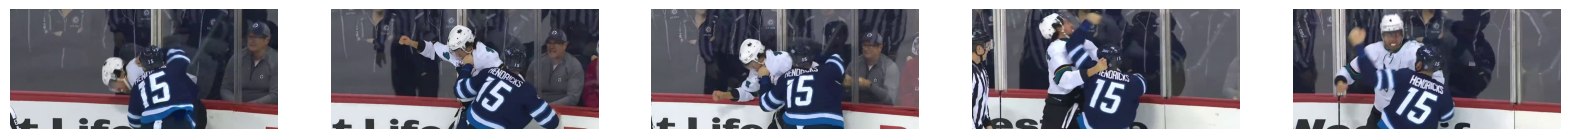

Displaying frames from a random non-violence video:


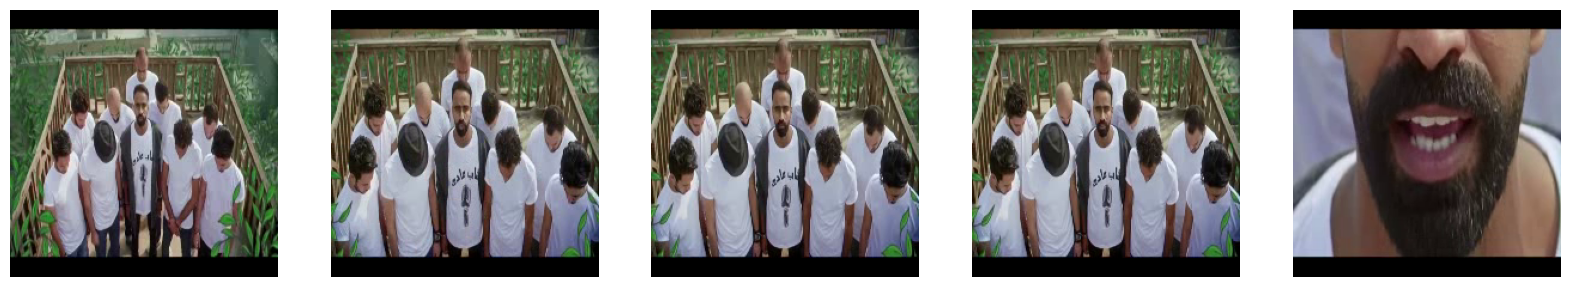

In [4]:
# Function to extract and display frames from a video
def display_video_frames(video_path, num_frames=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Sample frames evenly from the video
    frame_ids = random.sample(range(total_frames), num_frames)
    frame_ids.sort()
    
    for fid in frame_ids:
        cap.set(cv2.CAP_PROP_POS_FRAMES, fid)
        ret, frame = cap.read()
        if ret:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    cap.release()
    
    # Display the sampled frames
    plt.figure(figsize=(20, 10))
    for i, frame in enumerate(frames):
        plt.subplot(1, num_frames, i+1)
        plt.imshow(frame)
        plt.axis('off')
    plt.show()

# Randomly pick a violence and non-violence video to explore
random_violence_video = os.path.join(violence_path, random.choice(violence_videos))
random_nonviolence_video = os.path.join(nonviolence_path, random.choice(nonviolence_videos))

print("Displaying frames from a random violence video:")
display_video_frames(random_violence_video)

print("Displaying frames from a random non-violence video:")
display_video_frames(random_nonviolence_video)

In [5]:
def process_video(video_path, frame_size=(224, 224), nth_frame=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Process every nth frame
        if frame_count % nth_frame == 0:
            # Resize frame
            resized_frame = cv2.resize(frame, frame_size)
            # Normalize frame to [0, 1]
            normalized_frame = resized_frame / 255.0
            frames.append(normalized_frame)
        
        frame_count += 1

    cap.release()
    return np.array(frames)

# Example usage with a random video
random_video_path = os.path.join(violence_path, random.choice(violence_videos))
processed_frames = process_video(random_video_path, frame_size, nth_frame)

print(f"Processed {len(processed_frames)} frames from video: {random_video_path}")

Processed 15 frames from video: dataset/Real Life Violence Dataset\Violence\V_179.mp4


In [6]:
def process_dataset(video_paths, frame_size=(224, 224), nth_frame=10):
    all_frames = []
    
    for video_path in video_paths:
        video_frames = process_video(video_path, frame_size, nth_frame)
        all_frames.append(video_frames)
    
    return all_frames

# Get full paths to all videos
violence_video_paths = [os.path.join(violence_path, video) for video in violence_videos]
nonviolence_video_paths = [os.path.join(nonviolence_path, video) for video in nonviolence_videos]

# Process all videos
violence_frames = process_dataset(violence_video_paths, frame_size, nth_frame)
nonviolence_frames = process_dataset(nonviolence_video_paths, frame_size, nth_frame)

print(f"Processed {len(violence_frames)} violence videos and {len(nonviolence_frames)} non-violence videos.")

Processed 1000 violence videos and 1000 non-violence videos.


In [7]:
import os

# Create directories to store processed frames
os.makedirs('processed_violence', exist_ok=True)
os.makedirs('processed_nonviolence', exist_ok=True)

# Save each video's frames as a separate .npy file
for i, video_frames in enumerate(violence_frames):
    np.save(f'processed_violence/video_{i}.npy', video_frames)

for i, video_frames in enumerate(nonviolence_frames):
    np.save(f'processed_nonviolence/video_{i}.npy', video_frames)


In [8]:
# Load individual video frames
loaded_video_frames = np.load('processed_violence/video_0.npy')
loaded_video_frames

array([[[[0.24705882, 0.54509804, 0.7254902 ],
         [0.25490196, 0.56470588, 0.74117647],
         [0.23921569, 0.55686275, 0.73333333],
         ...,
         [0.6627451 , 0.6745098 , 0.58823529],
         [0.69019608, 0.70588235, 0.61176471],
         [0.72156863, 0.7372549 , 0.64313725]],

        [[0.2745098 , 0.54117647, 0.7254902 ],
         [0.25098039, 0.56078431, 0.7372549 ],
         [0.30196078, 0.58431373, 0.76470588],
         ...,
         [0.69411765, 0.70588235, 0.61960784],
         [0.70588235, 0.72156863, 0.62745098],
         [0.72156863, 0.7372549 , 0.64313725]],

        [[0.25098039, 0.50980392, 0.68627451],
         [0.28235294, 0.57254902, 0.74509804],
         [0.29803922, 0.57647059, 0.75294118],
         ...,
         [0.73333333, 0.73333333, 0.65098039],
         [0.73333333, 0.7372549 , 0.64705882],
         [0.70588235, 0.70980392, 0.61960784]],

        ...,

        [[0.23921569, 0.50588235, 0.59607843],
         [0.23529412, 0.48235294, 0.58431373]

In [9]:
def process_video(video_path, frame_size=(224, 224), nth_frame=10, normalize_range=(-1, 1)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    min_val, max_val = normalize_range

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Process every nth frame
        if frame_count % nth_frame == 0:
            # Resize frame
            resized_frame = cv2.resize(frame, frame_size)
            # Normalize frame to [-1, 1]
            normalized_frame = (resized_frame / 255.0) * (max_val - min_val) + min_val
            frames.append(normalized_frame)
        
        frame_count += 1

    cap.release()
    return np.array(frames)

# Example usage
random_video_path = os.path.join(violence_path, random.choice(violence_videos))
processed_frames = process_video(random_video_path, frame_size, nth_frame, normalize_range=(-1, 1))

print(f"Processed {len(processed_frames)} frames from video: {random_video_path}")

Processed 16 frames from video: dataset/Real Life Violence Dataset\Violence\V_214.mp4


### Model Development:

### CNN for Frame-Level Feature Extraction

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_feature_extractor(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    return model

cnn_model = build_cnn_feature_extractor((224, 224, 3))
cnn_model.summary()

c:\Users\garvi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,244,672 (84.86 MB)

 Trainable params: 22,244,672 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

### LSTM for Temporal Dependencies

In [11]:
from tensorflow.keras.layers import LSTM, TimeDistributed

def build_cnn_lstm_model(input_shape):
    cnn_model = build_cnn_feature_extractor(input_shape[1:])
    
    # Define the LSTM model
    model = models.Sequential()
    model.add(TimeDistributed(cnn_model, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn_lstm_model((None, 224, 224, 3))
model.summary()

c:\Users\garvi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 256)      │    22,244,672 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 128)      │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,491,265 (85.80 MB)

 Trainable params: 22,491,265 (85.80 MB)

 Non-trainable params: 0 (0.00 B)

### 3D CNN Architecture

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_3d_cnn_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling3D((1, 2, 2))(x)
    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((1, 2, 2))(x)
    x = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((1, 2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define input shape for 3D CNN: (sequence_length, height, width, channels)
input_shape = (10, 224, 224, 3)  # Example with 10 frames
model = build_3d_cnn_model(input_shape)
model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 10, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 10, 224, 224,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 10, 112, 112,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 10, 112, 112,   │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 10, 56, 56, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 10, 56, 56,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 10, 28, 28,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1003520)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │   256,901,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257,180,929 (981.07 MB)

 Trainable params: 257,180,929 (981.07 MB)

 Non-trainable params: 0 (0.00 B)

### Pre-Trained CNN Model as Feature Extractor

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

def build_transfer_learning_model(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_transfer_learning_model((224, 224, 3))
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Adding LSTM on Top of Transfer Learning

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16

def build_cnn_lstm_transfer_learning_model(input_shape):
    # Load pre-trained VGG16 model without the top layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape[1:])
    
    # Define the input for the sequence of frames
    inputs = layers.Input(shape=input_shape)
    
    # Apply TimeDistributed CNN model
    x = layers.TimeDistributed(base_model, input_shape=input_shape)(inputs)
    
    # Flatten the output of TimeDistributed
    x = layers.TimeDistributed(layers.Flatten())(x)
    
    # Add LSTM layers
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(64)(x)
    
    # Add Dense layer for classification
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Define input shape: (sequence_length, height, width, channels)
input_shape = (10, 224, 224, 3)  # Example with 10 frames
model = build_cnn_lstm_transfer_learning_model(input_shape)
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 10, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 7, 7, 512)  │    14,714,688 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 25088)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 128)        │    12,911,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,675,265 (105.57 MB)

 Trainable params: 27,675,265 (105.57 MB)

 Non-trainable params: 0 (0.00 B)

## Training and Validation:

### Loading Frames

In [15]:
import numpy as np
import os

def load_frames_from_directory(directory):
    frames_list = []
    for file_name in sorted(os.listdir(directory)):
        if file_name.endswith('.npy'):
            file_path = os.path.join(directory, file_name)
            frames = np.load(file_path)
            frames_list.append(frames)
    return np.concatenate(frames_list, axis=0)

# Load frames from directories
violence_frames = load_frames_from_directory('processed_violence')
nonviolence_frames = load_frames_from_directory('processed_nonviolence')

# Create labels
labels_violence = np.ones(violence_frames.shape[0])
labels_nonviolence = np.zeros(nonviolence_frames.shape[0])

# Concatenate frames and labels
X = np.concatenate((violence_frames, nonviolence_frames), axis=0)
y = np.concatenate((labels_violence, labels_nonviolence), axis=0)

print(f"Combined frames shape: {X.shape}")
print(f"Labels shape: {y.shape}")

### Splitting the Data

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

### Training the Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint, early_stopping]
)

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()